# CCL-SC on Long-Tailed CIFAR-10: Balanced and Worst-Group Analysis

This notebook evaluates **Class-wise Contrastive Learning for Selective Classification (CCL-SC)** on imbalanced CIFAR-10 with:
- **Balanced Error Rate**: Average error across all classes (unweighted)
- **Worst-Group Error Rate**: Error of the worst-performing class
- **AURC (Balanced)**: Area Under Risk-Coverage curve using balanced error
- **AURC (Worst-Group)**: Area Under Risk-Coverage curve using worst-group error

**Settings:**
- Architecture: VGG-16 with Batch Normalization
- Dataset: CIFAR-10 Long-Tailed (Imbalance Ratio configurable)
- Loss: CCL-SC (Contrastive Learning + SAT)
- Training: 300 epochs

## 1. Setup and Imports

In [ ]:
import os
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image

# For loading CIFAR-10-LT dataset
import datasets
from datasets import load_dataset

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Imports successful! All utilities will be embedded below...")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Long-Tailed Dataset Loading with HuggingFace Datasets

In [ ]:
# ============================================================================
# EMBEDDED UTILITY CLASSES AND FUNCTIONS
# ============================================================================

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class SelfAdaptiveTraining():
    """Self-Adaptive Training loss function"""
    def __init__(self, num_examples=50000, num_classes=10, mom=0.9):
        self.prob_history = torch.zeros(num_examples, num_classes)
        self.updated = torch.zeros(num_examples, dtype=torch.int)
        self.mom = mom
        self.num_classes = num_classes

    def _update_prob(self, prob, index, y):
        onehot = torch.zeros_like(prob)
        onehot[torch.arange(y.shape[0]), y] = 1
        prob_history = self.prob_history[index].clone().to(prob.device)

        cond = (self.updated[index] == 1).to(prob.device).unsqueeze(-1).expand_as(prob)
        prob_mom = torch.where(cond, prob_history, onehot)
        prob_mom = self.mom * prob_mom + (1 - self.mom) * prob

        self.updated[index] = 1
        self.prob_history[index] = prob_mom.to(self.prob_history.device)

        return prob_mom

    def __call__(self, logits, y, index):
        prob = F.softmax(logits.detach()[:, :self.num_classes], dim=1)
        prob = self._update_prob(prob, index, y)

        soft_label = torch.zeros_like(logits)
        soft_label[torch.arange(y.shape[0]), y] = prob[torch.arange(y.shape[0]), y]
        soft_label[:, -1] = 1 - prob[torch.arange(y.shape[0]), y]
        soft_label = F.normalize(soft_label, dim=1, p=1)
        loss = torch.sum(-F.log_softmax(logits, dim=1) * soft_label, dim=1)
        return torch.mean(loss)


print("✅ Utility classes embedded successfully!")

CIFAR-10-LT wrapper class defined.


In [ ]:
# ============================================================================
# VGG-16 MODEL WITH FEATURE EXTRACTION (Embedded)
# ============================================================================

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, input_size=32):
        super(VGG, self).__init__()
        self.features = features
        if input_size == 32:
            self.classifier = nn.Sequential(
                nn.Linear(512, 512), nn.ReLU(inplace=True),
                nn.BatchNorm1d(512), nn.Dropout2d(0.5),
                nn.Linear(512, num_classes)
            )
        elif input_size == 64:
            self.classifier = nn.Sequential(
                nn.Linear(2048, 512), nn.ReLU(inplace=True),
                nn.BatchNorm1d(512), nn.Dropout2d(0.5),
                nn.Linear(512, num_classes)
            )
        self._initialize_weights()

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        if return_features:
            # For CCL-SC: return both logits and features (before final layer)
            features = self.classifier[:-1](x)  # Up to last linear layer
            logits = self.classifier[-1](features)
            return logits, features
        else:
            x = self.classifier(x)
            return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif type(v) == int:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.ReLU(inplace=True), nn.BatchNorm2d(v)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
        elif type(v) == float:
            layers += [nn.Dropout2d(v)]
    return nn.Sequential(*layers)


cfg_vgg16 = {
    'D': [64, 0.3, 64, 'M', 128, 0.4, 128, 'M', 256, 0.4, 256, 0.4, 256, 'M',
          512, 0.4, 512, 0.4, 512, 'M', 512, 0.4, 512, 0.4, 512, 'M', 0.5]
}


def vgg16_bn(num_classes=1000, input_size=32, **kwargs):
    """VGG 16-layer model with batch normalization and optional feature extraction"""
    model = VGG(make_layers(cfg_vgg16['D'], batch_norm=True), 
                num_classes=num_classes, input_size=input_size, **kwargs)
    return model


# ============================================================================
# MOCO MODULE FOR CONTRASTIVE LEARNING (Embedded)
# ============================================================================

class MoCo(nn.Module):
    """Momentum Contrast module for Class-wise Contrastive Learning"""
    
    def __init__(self, dim=128, K=65536, m=0.999, T=0.07, num_class=10, mlp=False):
        super(MoCo, self).__init__()
        self.base_temperature = 0.10
        self.K = K
        self.K2 = K
        self.m = m
        self.T = T

        # Error queue
        self.register_buffer("queue", torch.randn(dim, self.K2))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("prediction_queue", torch.randint(low=0, high=num_class, size=(self.K2,), dtype=torch.long))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

        # Correct queue
        self.register_buffer("correct_queue", torch.randn(dim, K))
        self.correct_queue = nn.functional.normalize(self.correct_queue, dim=0)
        self.register_buffer("correct_prediction_queue", torch.randint(low=0, high=num_class, size=(K,), dtype=torch.long))
        self.register_buffer("correct_queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _dequeue_and_enqueue(self, k_error, k_correct, correct_predicts, error_predicts):
        batch_size = k_error.shape[0]
        ptr = int(self.queue_ptr)
        full_k1 = False
        full_k2 = False

        if ptr + batch_size >= self.K2:
            self.queue[:, ptr : self.K2] = k_error[:self.K2 - ptr, :].T
            self.queue[:, : batch_size - self.K2 + ptr] = k_error[self.K2 - ptr :, :].T
            self.prediction_queue[ptr : self.K2] = error_predicts[:self.K2 - ptr]
            self.prediction_queue[: batch_size - self.K2 + ptr] = error_predicts[self.K2 - ptr :]
            ptr = batch_size - self.K2 + ptr
            full_k1 = True
        else:
            self.queue[:, ptr : ptr + batch_size] = k_error.T
            self.prediction_queue[ptr : ptr + batch_size] = error_predicts
            ptr = (ptr + batch_size) % self.K2

        self.queue_ptr[0] = ptr

        batch_size = correct_predicts.shape[0]
        ptr = int(self.correct_queue_ptr)
        
        if ptr + batch_size >= self.K:
            self.correct_queue[:, ptr : self.K] = k_correct[:self.K - ptr, :].T
            self.correct_queue[:, : batch_size - self.K + ptr] = k_correct[self.K - ptr :, :].T
            self.correct_prediction_queue[ptr : self.K] = correct_predicts[:self.K - ptr]
            self.correct_prediction_queue[: batch_size - self.K + ptr] = correct_predicts[self.K - ptr :]
            ptr = batch_size - self.K + ptr
            full_k2 = True
        else:
            self.correct_queue[:, ptr : ptr + batch_size] = k_correct.T
            self.correct_prediction_queue[ptr : ptr + batch_size] = correct_predicts
            ptr = (ptr + batch_size) % self.K

        self.correct_queue_ptr[0] = ptr
        return full_k1, full_k2

    def forward(self, hidden_features, hidden_features_k, targets, outputs, outputs_k, epoch, pretrain, full_flag):
        predicted_k = outputs_k.argmax(dim=1)
        correct_mask_k = (predicted_k == targets.cuda())
        correct_predicts_k = predicted_k[correct_mask_k]
        error_predicts_k = predicted_k[~correct_mask_k]
        
        predicted = outputs.argmax(dim=1)
        outputs_soft = F.softmax(outputs, dim=1)
        sr = outputs_soft.max(1).values.detach()
        correct_mask = (predicted == targets.cuda())
        correct_predicts = predicted[correct_mask]
        error_predicts = predicted[~correct_mask]
        
        with torch.no_grad():
            k_error = hidden_features_k[~correct_mask_k].cuda()
            k_error = nn.functional.normalize(k_error, dim=1)
            k_correct = hidden_features_k[correct_mask_k].cuda()
            k_correct = nn.functional.normalize(k_correct, dim=1)

        if epoch >= pretrain and full_flag:
            q = hidden_features.cuda()
            q = nn.functional.normalize(q, dim=1)

            # Contrastive loss calculation
            sim_matrix = torch.matmul(q, self.queue.detach().cuda())
            eq_matrix = torch.eq(targets.view(-1, 1), self.prediction_queue.detach().view(1, -1).cuda())
            sim_matrix *= eq_matrix
            sim_matrix += (eq_matrix == False).float() * -1e9
            del eq_matrix

            sim_matrix_tp = torch.matmul(q, self.correct_queue.detach().cuda())
            eq_matrix_tp = torch.eq(targets.view(-1, 1), self.correct_prediction_queue.detach().view(1, -1).cuda())
            sim_matrix_tp *= eq_matrix_tp
            sim_matrix_tp = sim_matrix_tp[eq_matrix_tp]
            non_zero_counts = (eq_matrix_tp != 0).sum(dim=1).cuda()
            expanded_non_zero_counts = (non_zero_counts / sr).repeat_interleave(non_zero_counts)
            del eq_matrix_tp

            expanded_sim_matrix = sim_matrix.repeat_interleave(non_zero_counts, dim=0)
            del sim_matrix
            
            logits_t = torch.cat([sim_matrix_tp.unsqueeze(-1), expanded_sim_matrix], dim=1)
            logits_t /= self.T
            logits_t = logits_t - logits_t.max(dim=1, keepdim=True).values
            exp_logits_t = logits_t.exp()
            logsumexp_t = exp_logits_t.sum(dim=1).log()
            del logits_t, exp_logits_t
            
            info_nce_loss_t = logsumexp_t - sim_matrix_tp
            info_nce_loss_t /= expanded_non_zero_counts
            info_nce_loss_t = torch.sum(info_nce_loss_t) / q.shape[0]

            full_k1, full_k2 = self._dequeue_and_enqueue(k_error, k_correct, correct_predicts_k, error_predicts_k)
            return full_k1, full_k2, sum(correct_mask_k).item() / int(targets.size().numel()), (self.T / self.base_temperature) * info_nce_loss_t
        
        full_k1, full_k2 = self._dequeue_and_enqueue(k_error, k_correct, correct_predicts_k, error_predicts_k)
        return full_k1, full_k2, sum(correct_mask_k).item() / int(targets.size().numel())


print("✅ VGG-16 model and MoCo module embedded successfully!")

## 3. Configuration

In [17]:
# Configuration
class Config:
    # Dataset settings
    dataset = 'cifar10'
    dataset_name = 'r-100'  # HuggingFace dataset name: r-10, r-20, r-50, r-100, r-200
    imbalance_ratio = 100  # Majority/minority class ratio (10, 20, 50, 100, 200)
    
    # Architecture
    arch = 'vgg16_bn'
    
    # Training settings
    loss_type = 'csc'  # CCL-SC loss
    epochs = 300
    pretrain_epochs = 0
    
    # Hyperparameters
    batch_size_train = 64  # CCL-SC uses 64
    batch_size_test = 200
    lr = 0.1
    momentum = 0.9
    sat_momentum = 0.9  # For SAT component
    weight_decay = 5e-4
    gamma = 0.5
    schedule = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275]
    
    # CCL-SC specific parameters
    moco_k = 300  # Queue size for contrastive learning
    moco_m = 0.999  # Momentum for updating key encoder
    temperature = 0.07  # Temperature for contrastive loss
    feature_dim = 128  # Feature dimension for contrastive learning
    
    # Evaluation settings
    expected_coverage = [100., 99., 98., 97., 95., 90., 85., 80., 75., 70., 60., 50., 40., 30., 20., 10.]
    
    # System settings
    gpu_id = '0'
    num_workers = 4
    manual_seed = 42
    save_dir = f'./checkpoints/cclsc_longtailed_ir{100}'
    
config = Config()

# Set random seeds
random.seed(config.manual_seed)
torch.manual_seed(config.manual_seed)
np.random.seed(config.manual_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.manual_seed)

# Set GPU
os.environ['CUDA_VISIBLE_DEVICES'] = config.gpu_id
use_cuda = torch.cuda.is_available()

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

print(f"Configuration:")
print(f"  Dataset: Long-Tailed CIFAR-10 (dataset_name={config.dataset_name}, IR={config.imbalance_ratio})")
print(f"  Architecture: {config.arch}")
print(f"  Loss: {config.loss_type} (CCL-SC)")
print(f"  Epochs: {config.epochs}")
print(f"  MoCo Queue Size: {config.moco_k}")
print(f"  Temperature: {config.temperature}")
print(f"  Save directory: {config.save_dir}")

Configuration:
  Dataset: Long-Tailed CIFAR-10 (dataset_name=r-100, IR=100)
  Architecture: vgg16_bn
  Loss: csc (CCL-SC)
  Epochs: 300
  MoCo Queue Size: 300
  Temperature: 0.07
  Save directory: ./checkpoints/cclsc_longtailed_ir100


## 4. Dataset Preparation

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


Preparing Long-Tailed CIFAR-10 from HuggingFace (dataset=r-100)...
Loading dataset from cifar10-lt.py script...

Training samples: 2478
Test samples: 10000
Number of classes: 10


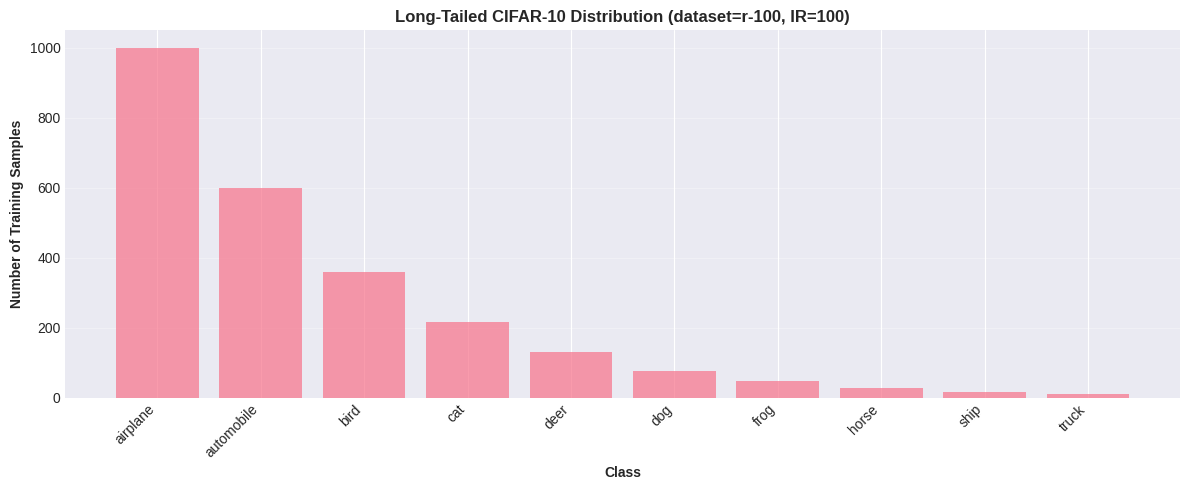


Class distribution saved to ./checkpoints/cclsc_longtailed_ir100/dataset_distribution.png


In [18]:
# Prepare datasets
print(f'Preparing Long-Tailed CIFAR-10 from HuggingFace (dataset={config.dataset_name})...')

num_classes = 10
input_size = 32

# CCL-SC uses data augmentation with two different views
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load HuggingFace CIFAR-10-LT dataset
print(f"Loading dataset from cifar10-lt.py script...")
hf_train = load_dataset('./cifar10-lt.py', name=config.dataset_name, split='train')
hf_test = load_dataset('./cifar10-lt.py', name=config.dataset_name, split='test')

# Wrap with PyTorch-compatible wrapper
trainset = CIFAR10LTWrapper(hf_train, transform=transform_train)
testset = CIFAR10LTWrapper(hf_test, transform=transform_test)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=config.batch_size_train, 
                        shuffle=True, num_workers=config.num_workers)
testloader = DataLoader(testset, batch_size=config.batch_size_test, 
                       shuffle=False, num_workers=config.num_workers)

print(f"\nTraining samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {num_classes}")

# Visualize distribution
train_dist = trainset.get_class_distribution()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(num_classes), [train_dist[i] for i in range(num_classes)], alpha=0.7)
ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Number of Training Samples', fontweight='bold')
ax.set_title(f'Long-Tailed CIFAR-10 Distribution (dataset={config.dataset_name}, IR={config.imbalance_ratio})', fontweight='bold')
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'dataset_distribution.png'), dpi=150)
plt.show()

print(f"\nClass distribution saved to {config.save_dir}/dataset_distribution.png")

## 5. Model Setup with CCL-SC

CCL-SC combines:
1. **Base classifier** (VGG-16) with selective classification output
2. **MoCo contrastive learning** module for feature learning
3. **SAT loss** for selective classification

In [ ]:
# ============================================================================
# Model Setup with CCL-SC (Momentum Contrast)
# ============================================================================

print(f"Creating models for CCL-SC...")

model_num_classes = num_classes + 1  # Extra dimension for abstention

# Query encoder (main model)
model = vgg16_bn(num_classes=model_num_classes, input_size=input_size)

# Key encoder (momentum model)
model_k = vgg16_bn(num_classes=model_num_classes, input_size=input_size)

# Initialize key encoder with same weights
for param_q, param_k in zip(model.parameters(), model_k.parameters()):
    param_k.data.copy_(param_q.data)
    param_k.requires_grad = False  # Key encoder not updated by gradients

if use_cuda:
    model = torch.nn.DataParallel(model.cuda())
    model_k = torch.nn.DataParallel(model_k.cuda())
    cudnn.benchmark = True

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters (query encoder): {total_params/1e6:.2f}M")
print(f"Total parameters (key encoder): {total_params/1e6:.2f}M")

# Setup MoCo module for contrastive learning
moco = MoCo(dim=512, K=300, m=config.moco_m, T=config.moco_T, num_class=num_classes)
if use_cuda:
    moco = moco.cuda()

print(f"MoCo module initialized (K={config.moco_K}, m={config.moco_m}, T={config.moco_T})")

# Setup SAT loss function
criterion_sat = SelfAdaptiveTraining(num_examples=len(trainset), num_classes=num_classes, mom=config.sat_momentum)

# Setup optimizer
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

print(f"Loss function: SAT + Contrastive (CCL-SC)")
print(f"Optimizer: SGD (lr={config.lr}, momentum={config.momentum}, weight_decay={config.weight_decay})")
print(f"✅ CCL-SC model setup complete!")

Creating model: vgg16_bn
Total parameters: 15.32M
Loss function: CCL-SC (Contrastive + SAT)
Optimizer: SGD (lr=0.1, momentum=0.9, weight_decay=0.0005)
MoCo queue initialized


## 6. Training Functions with CCL-SC and Group-Aware Metrics

CCL-SC training involves:
1. **Forward pass** through both query (model) and key (model_k) encoders
2. **Contrastive loss** computation using MoCo queues
3. **SAT loss** for selective classification
4. **Momentum update** of key encoder

In [20]:
# Global flags for MoCo queue initialization
full_k1 = False
full_k2 = False

def train_epoch_cclsc(trainloader, model, model_k, moco, criterion_sat, optimizer, epoch, use_cuda, config):
    """Train for one epoch with CCL-SC"""
    global full_k1, full_k2
    
    model.train()
    model_k.train()
    
    losses = AverageMeter()
    losses_sat = AverageMeter()
    losses_contrastive = AverageMeter()
    top1 = AverageMeter()
    
    # Track per-class accuracy
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    
    # Momentum update of key encoder
    if epoch == config.pretrain_epochs:
        # Initialize key encoder at start of contrastive learning
        for param_q, param_k in zip(model.parameters(), model_k.parameters()):
            param_k.data.copy_(param_q.data)
    elif epoch > config.pretrain_epochs:
        # Momentum update
        for param_q, param_k in zip(model.parameters(), model_k.parameters()):
            param_k.data = param_k.data * config.moco_m + param_q.data * (1.0 - config.moco_m)
    
    for batch_idx, batch_data in enumerate(trainloader):
        inputs, targets, indices = batch_data
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # Forward pass through query encoder (with features)
        outputs, features = model(inputs, return_features=True)
        
        # Forward pass through key encoder (no grad)
        with torch.no_grad():
            outputs_k, features_k = model_k(inputs, return_features=True)
        
        # SAT loss (always computed)
        if epoch >= config.pretrain_epochs:
            loss_sat = criterion_sat(outputs, targets, indices)
        else:
            loss_sat = F.cross_entropy(outputs[:, :-1], targets)
        
        # Contrastive loss (after warmup and queue is full)
        loss_contrastive = torch.tensor(0.0).cuda() if use_cuda else torch.tensor(0.0)
        if epoch >= config.pretrain_epochs and full_k1 and full_k2:
            temp_full_k1, temp_full_k2, moco_acc, loss_contrastive = moco(
                features, features_k, targets, outputs, outputs_k, 
                epoch, config.pretrain_epochs, full_k1 and full_k2
            )
            full_k1 = full_k1 or temp_full_k1
            full_k2 = full_k2 or temp_full_k2
        else:
            # Queue update even before fully initialized (returns only 3 values)
            moco_result = moco(
                features, features_k, targets, outputs, outputs_k, 
                epoch, config.pretrain_epochs, False
            )
            temp_full_k1, temp_full_k2, moco_acc = moco_result
            full_k1 = full_k1 or temp_full_k1
            full_k2 = full_k2 or temp_full_k2
        
        # Combined loss
        if epoch >= config.pretrain_epochs and full_k1 and full_k2:
            loss = loss_sat + loss_contrastive * 2.2  # reward weight for contrastive loss
        else:
            loss = loss_sat
        
        # Measure accuracy
        prec1 = accuracy(outputs.data, targets.data, topk=(1,))[0]
        losses.update(loss.item(), inputs.size(0))
        losses_sat.update(loss_sat.item(), inputs.size(0))
        if loss_contrastive.item() > 0:
            losses_contrastive.update(loss_contrastive.item(), inputs.size(0))
        top1.update(prec1.item(), inputs.size(0))
        
        # Per-class statistics
        _, predicted = outputs[:, :-1].max(1)
        for i in range(num_classes):
            mask = targets == i
            if mask.sum() > 0:
                class_correct[i] += (predicted[mask] == targets[mask]).sum().item()
                class_total[i] += mask.sum().item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Calculate balanced accuracy
    class_acc = []
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc.append(100.0 * class_correct[i] / class_total[i])
        else:
            class_acc.append(0.0)
    
    balanced_acc = np.mean(class_acc)
    worst_acc = np.min(class_acc)
    
    return losses.avg, losses_sat.avg, losses_contrastive.avg, top1.avg, balanced_acc, worst_acc

def test_epoch(testloader, model, criterion_sat, epoch, use_cuda, config):
    """Test for one epoch with group-aware metrics"""
    model.eval()
    
    losses = AverageMeter()
    top1 = AverageMeter()
    
    # Track per-class statistics
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)
    
    # Store predictions for coverage analysis
    all_reservations = []
    all_predictions = []
    all_targets = []
    all_correct = []
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(testloader):
            inputs, targets, indices = batch_data
            
            if use_cuda:
                inputs = inputs.cuda()
            
            outputs = model(inputs).cpu()
            
            # Calculate loss
            if epoch >= config.pretrain_epochs:
                loss = F.cross_entropy(outputs[:, :-1], targets)
                
                # Get reservation scores
                outputs_soft = F.softmax(outputs, dim=1)
                class_probs = outputs_soft[:, :-1]
                reservation = outputs_soft[:, -1]
                
                _, predictions = class_probs.max(1)
            else:
                loss = F.cross_entropy(outputs[:, :-1], targets)
                _, predictions = outputs[:, :-1].max(1)
                reservation = torch.zeros(len(targets))
            
            # Overall accuracy
            prec1 = accuracy(outputs[:, :-1].data, targets.data, topk=(1,))[0]
            losses.update(loss.item(), inputs.size(0))
            top1.update(prec1.item(), inputs.size(0))
            
            # Per-class statistics
            correct = predictions == targets
            for i in range(num_classes):
                mask = targets == i
                if mask.sum() > 0:
                    class_correct[i] += correct[mask].sum().item()
                    class_total[i] += mask.sum().item()
            
            # Store for coverage analysis
            all_reservations.extend(reservation.numpy().tolist())
            all_predictions.extend(predictions.numpy().tolist())
            all_targets.extend(targets.numpy().tolist())
            all_correct.extend(correct.numpy().tolist())
    
    # Calculate balanced and worst-group accuracy
    class_acc = []
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc.append(100.0 * class_correct[i] / class_total[i])
        else:
            class_acc.append(0.0)
    
    balanced_acc = np.mean(class_acc)
    worst_acc = np.min(class_acc)
    
    # Calculate coverage-based metrics
    coverage_results = calculate_group_coverage_metrics(
        np.array(all_reservations),
        np.array(all_predictions),
        np.array(all_targets),
        np.array(all_correct),
        config.expected_coverage
    )
    
    return losses.avg, top1.avg, balanced_acc, worst_acc, class_acc, coverage_results

def calculate_group_coverage_metrics(reservations, predictions, targets, correct, coverages):
    """Calculate balanced and worst-group error at different coverage levels"""
    results = []
    
    # Sort by reservation (high to low - high reservation = less confident = more likely to abstain)
    sorted_indices = np.argsort(reservations)[::-1]
    sorted_correct = correct[sorted_indices]
    sorted_targets = targets[sorted_indices]
    
    for coverage in coverages:
        # Select samples based on coverage (exclude high reservation samples)
        n_samples = int(len(reservations) * coverage / 100)
        if n_samples == 0:
            continue
        
        # Take samples starting from lowest reservation (most confident)
        selected_correct = sorted_correct[-n_samples:]
        selected_targets = sorted_targets[-n_samples:]
        
        # Calculate per-class error
        class_errors = []
        for cls in range(num_classes):
            mask = selected_targets == cls
            if mask.sum() > 0:
                cls_error = 100.0 * (1 - selected_correct[mask].mean())
                class_errors.append(cls_error)
            else:
                class_errors.append(0.0)  # No samples for this class at this coverage
        
        balanced_error = np.mean(class_errors)
        worst_error = np.max(class_errors)
        overall_error = 100.0 * (1 - selected_correct.mean())
        
        results.append({
            'coverage': coverage,
            'overall_error': overall_error,
            'balanced_error': balanced_error,
            'worst_group_error': worst_error,
            'class_errors': class_errors
        })
    
    return results

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## 7. Training Loop

In [21]:
# Training history
history = {
    'epoch': [],
    'train_loss': [],
    'train_loss_sat': [],
    'train_loss_contrastive': [],
    'train_acc': [],
    'train_balanced_acc': [],
    'train_worst_acc': [],
    'test_loss': [],
    'test_acc': [],
    'test_balanced_acc': [],
    'test_worst_acc': [],
    'test_class_acc': [],
    'coverage_results': []
}

print(f"Starting training for {config.epochs} epochs...")
print("=" * 120)
print(f"{'Epoch':>5} | {'LR':>10} | {'Loss SAT':>10} | {'Loss Con':>10} | {'Train Acc':>10} | {'Bal Acc':>10} | {'Worst Acc':>10} | {'Test Acc':>10} | {'Bal Acc':>10} | {'Worst Acc':>10} | {'Time':>6} | {'Status'}")
print("=" * 120)

best_balanced_acc = 0.0
best_worst_acc = 0.0
start_time = time.time()

for epoch in range(config.epochs):
    epoch_start = time.time()
    
    # Adjust learning rate
    if epoch in config.schedule:
        config.lr *= config.gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = config.lr
    
    # Train with CCL-SC
    train_loss, train_loss_sat, train_loss_con, train_acc, train_bal_acc, train_worst_acc = train_epoch_cclsc(
        trainloader, model, model_k, moco, criterion_sat, optimizer, epoch, use_cuda, config
    )
    
    # Test
    test_loss, test_acc, test_bal_acc, test_worst_acc, test_class_acc, coverage_results = test_epoch(
        testloader, model, criterion_sat, epoch, use_cuda, config
    )
    
    # Save history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['train_loss_sat'].append(train_loss_sat)
    history['train_loss_contrastive'].append(train_loss_con)
    history['train_acc'].append(train_acc)
    history['train_balanced_acc'].append(train_bal_acc)
    history['train_worst_acc'].append(train_worst_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['test_balanced_acc'].append(test_bal_acc)
    history['test_worst_acc'].append(test_worst_acc)
    history['test_class_acc'].append(test_class_acc)
    history['coverage_results'].append(coverage_results)
    
    epoch_time = time.time() - epoch_start
    
    # Track best models
    status = ""
    if test_bal_acc > best_balanced_acc:
        best_balanced_acc = test_bal_acc
        checkpoint_path = os.path.join(config.save_dir, 'best_balanced_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'balanced_acc': best_balanced_acc,
        }, checkpoint_path)
        status += "*BAL* "
    
    if test_worst_acc > best_worst_acc:
        best_worst_acc = test_worst_acc
        checkpoint_path = os.path.join(config.save_dir, 'best_worst_model.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'worst_acc': best_worst_acc,
        }, checkpoint_path)
        status += "*WORST*"
    
    # Compact output
    print(f"{epoch+1:5d} | {config.lr:10.6f} | {train_loss_sat:10.4f} | {train_loss_con:10.4f} | {train_acc:9.2f}% | {train_bal_acc:9.2f}% | {train_worst_acc:9.2f}% | "
          f"{test_acc:9.2f}% | {test_bal_acc:9.2f}% | {test_worst_acc:9.2f}% | {epoch_time:5.1f}s | {status}")
    
    # Save periodic checkpoint
    if (epoch + 1) % 50 == 0 or (epoch + 1) == config.epochs:
        checkpoint_path = os.path.join(config.save_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(model, checkpoint_path)

total_time = time.time() - start_time
print("\n" + "=" * 120)
print(f"Training completed in {total_time/3600:.2f} hours")
print(f"Best balanced accuracy: {best_balanced_acc:.2f}%")
print(f"Best worst-group accuracy: {best_worst_acc:.2f}%")
print("=" * 120)

Starting training for 300 epochs...
Epoch |         LR |   Loss SAT |   Loss Con |  Train Acc |    Bal Acc |  Worst Acc |   Test Acc |    Bal Acc |  Worst Acc |   Time | Status


/home/viet2005/workspace/Research/ltr_xai/SAT-Ensemble/venv/lib/python3.12/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


    1 |   0.100000 |     3.8183 |     0.0000 |     27.40% |     10.58% |      0.00% |     10.01% |     10.01% |      0.00% |   3.5s | *BAL* 
    2 |   0.100000 |     3.5219 |     0.0828 |     29.10% |     10.47% |      0.00% |     10.01% |     10.01% |      0.00% |   2.9s | 
    3 |   0.100000 |     2.5857 |     0.0078 |     30.51% |     10.89% |      0.00% |     11.40% |     11.40% |      0.00% |   2.7s | *BAL* 
    4 |   0.100000 |     2.4403 |     0.0123 |     28.77% |     11.53% |      0.00% |     13.27% |     13.27% |      0.00% |   2.7s | *BAL* 
    5 |   0.100000 |     2.0208 |     0.0097 |     23.00% |     11.05% |      0.00% |     10.00% |     10.00% |      0.00% |   2.7s | 
    6 |   0.100000 |     1.8521 |     0.0100 |     20.42% |     11.11% |      0.00% |     14.62% |     14.62% |      0.00% |   2.6s | *BAL* 
    7 |   0.100000 |     1.7288 |     0.0049 |     18.04% |     11.00% |      0.00% |     11.53% |     11.53% |      0.00% |   2.6s | 
    8 |   0.100000 |     1.5615

## 8. Visualization: Training Dynamics

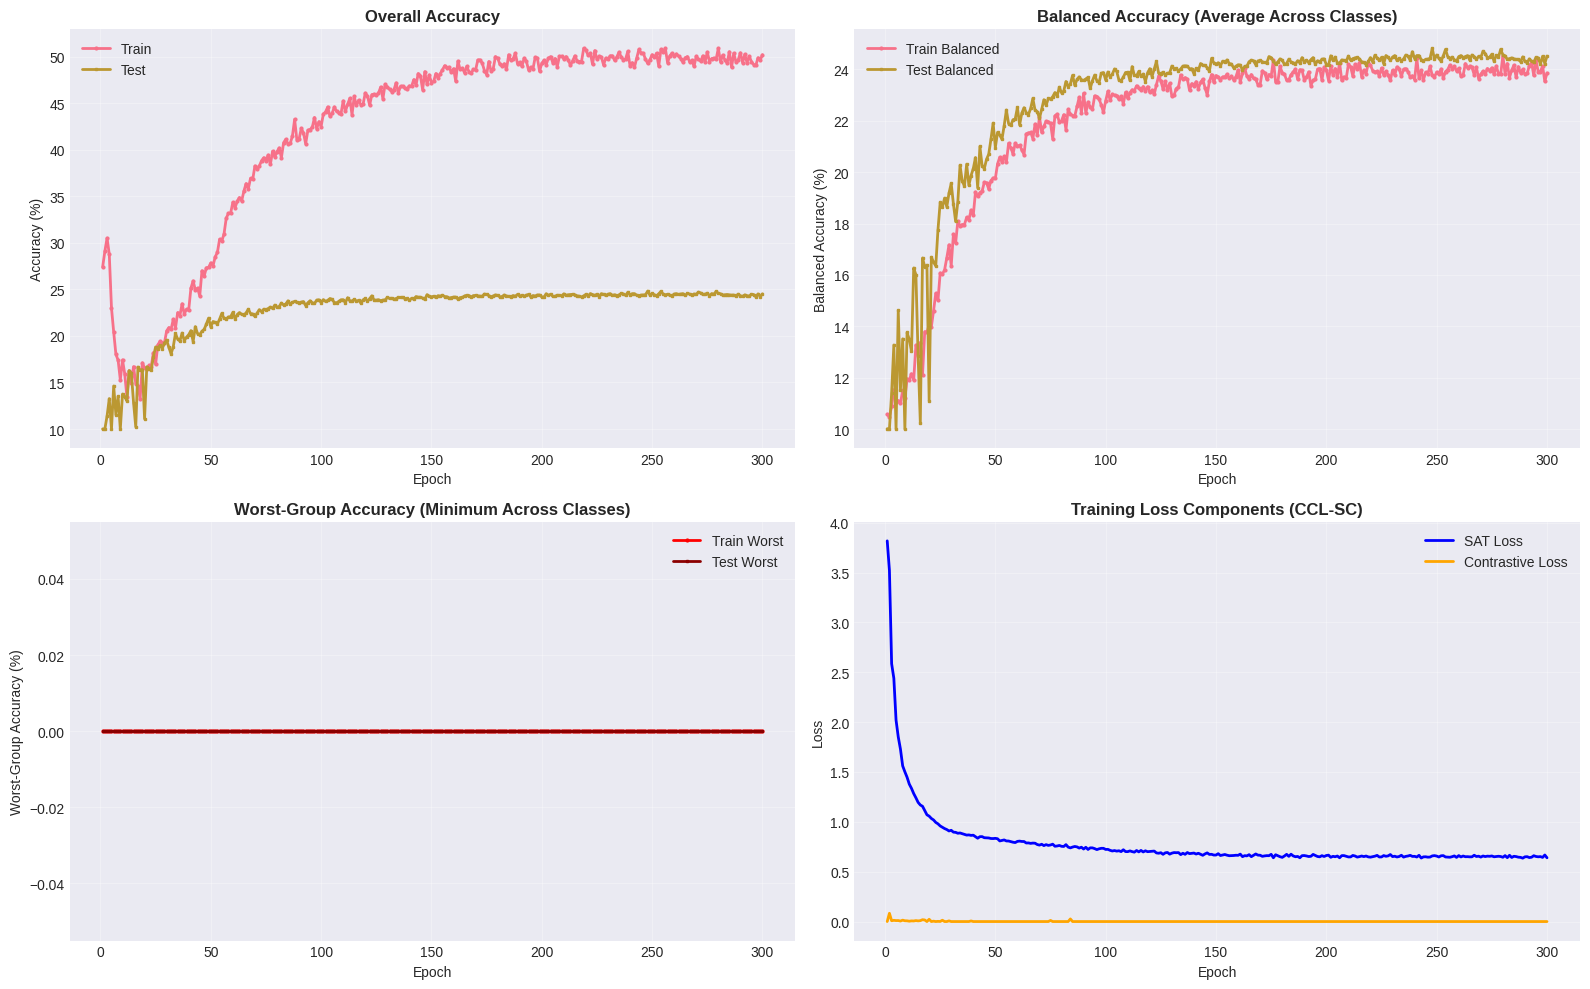

Training curves saved to ./checkpoints/cclsc_longtailed_ir100/training_curves.png


In [22]:
# Training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Overall accuracy
ax = axes[0, 0]
ax.plot(history['epoch'], history['train_acc'], label='Train', linewidth=2, marker='o', markersize=2)
ax.plot(history['epoch'], history['test_acc'], label='Test', linewidth=2, marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Overall Accuracy', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Balanced accuracy
ax = axes[0, 1]
ax.plot(history['epoch'], history['train_balanced_acc'], label='Train Balanced', linewidth=2, marker='o', markersize=2)
ax.plot(history['epoch'], history['test_balanced_acc'], label='Test Balanced', linewidth=2, marker='s', markersize=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Balanced Accuracy (%)')
ax.set_title('Balanced Accuracy (Average Across Classes)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Worst-group accuracy
ax = axes[1, 0]
ax.plot(history['epoch'], history['train_worst_acc'], label='Train Worst', linewidth=2, marker='o', markersize=2, color='red')
ax.plot(history['epoch'], history['test_worst_acc'], label='Test Worst', linewidth=2, marker='s', markersize=2, color='darkred')
ax.set_xlabel('Epoch')
ax.set_ylabel('Worst-Group Accuracy (%)')
ax.set_title('Worst-Group Accuracy (Minimum Across Classes)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Loss components (SAT + Contrastive)
ax = axes[1, 1]
ax.plot(history['epoch'], history['train_loss_sat'], label='SAT Loss', linewidth=2, color='blue')
ax.plot(history['epoch'], history['train_loss_contrastive'], label='Contrastive Loss', linewidth=2, color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss Components (CCL-SC)', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'training_curves.png'), dpi=150)
plt.show()

print(f"Training curves saved to {config.save_dir}/training_curves.png")

## 9. Per-Class Performance Analysis


Final Per-Class Performance:


,Class,Train Samples,Test Accuracy (%),Test Error (%)
0,airplane,1000,92.1,7.9
1,automobile,599,81.8,18.2
2,bird,359,71.3,28.7
3,cat,215,0.0,100.0
4,deer,129,0.0,100.0
5,dog,77,0.0,100.0
6,frog,46,0.0,100.0
7,horse,27,0.0,100.0
8,ship,16,0.0,100.0
9,truck,10,0.0,100.0


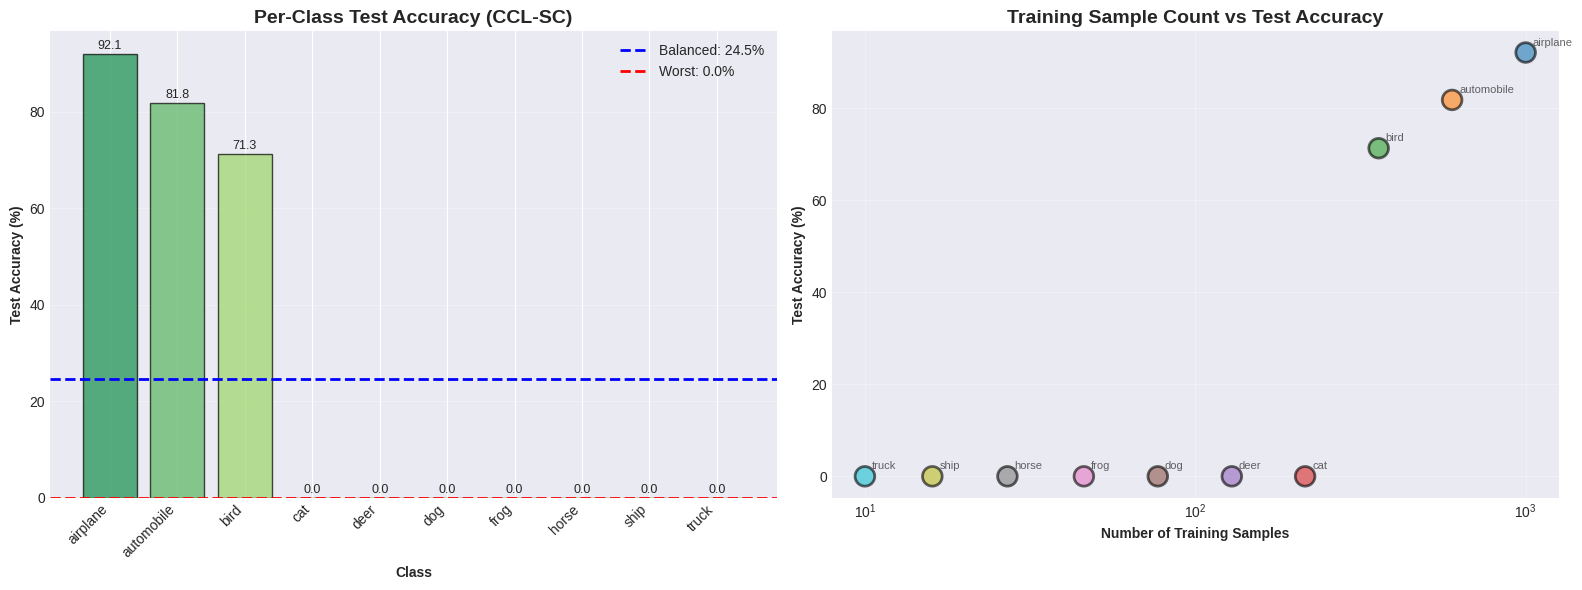


Per-class analysis saved to ./checkpoints/cclsc_longtailed_ir100/per_class_performance.png


In [23]:
# Analyze final per-class performance
final_class_acc = history['test_class_acc'][-1]
train_dist = trainset.get_class_distribution()

# Create DataFrame
df_class_perf = pd.DataFrame({
    'Class': class_names,
    'Train Samples': [train_dist[i] for i in range(num_classes)],
    'Test Accuracy (%)': final_class_acc,
    'Test Error (%)': [100 - acc for acc in final_class_acc]
})

print("\nFinal Per-Class Performance:")
display(df_class_perf)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy by class
ax = axes[0]
colors = plt.cm.RdYlGn(np.array(final_class_acc) / 100)
bars = ax.bar(range(num_classes), final_class_acc, color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontweight='bold')
ax.set_title('Per-Class Test Accuracy (CCL-SC)', fontweight='bold', fontsize=14)
ax.set_xticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.axhline(y=np.mean(final_class_acc), color='blue', linestyle='--', linewidth=2, label=f'Balanced: {np.mean(final_class_acc):.1f}%')
ax.axhline(y=np.min(final_class_acc), color='red', linestyle='--', linewidth=2, label=f'Worst: {np.min(final_class_acc):.1f}%')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, acc in enumerate(final_class_acc):
    ax.text(i, acc + 1, f'{acc:.1f}', ha='center', fontsize=9)

# 2. Training samples vs accuracy
ax = axes[1]
train_samples = [train_dist[i] for i in range(num_classes)]
scatter = ax.scatter(train_samples, final_class_acc, s=200, alpha=0.6, c=range(num_classes), 
                     cmap='tab10', edgecolors='black', linewidth=2)
ax.set_xlabel('Number of Training Samples', fontweight='bold')
ax.set_ylabel('Test Accuracy (%)', fontweight='bold')
ax.set_title('Training Sample Count vs Test Accuracy', fontweight='bold', fontsize=14)
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

# Add class labels
for i, name in enumerate(class_names):
    ax.annotate(name, (train_samples[i], final_class_acc[i]), 
                fontsize=8, alpha=0.7, xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'per_class_performance.png'), dpi=150)
plt.show()

print(f"\nPer-class analysis saved to {config.save_dir}/per_class_performance.png")

## 10. Coverage-Based Analysis: Balanced and Worst-Group Error


Coverage-Based Error Analysis:


,coverage,overall_error,balanced_error,worst_group_error
0,100.0,75.480000,75.480000,100.0
1,99.0,75.333333,75.476138,100.0
2,98.0,75.153061,75.488528,100.0
3,97.0,74.979381,75.504213,100.0
4,95.0,74.610526,75.507738,100.0
5,90.0,73.588889,75.558002,100.0
6,85.0,72.447059,75.489420,100.0
7,80.0,71.350000,75.424972,100.0
8,75.0,69.933333,75.312204,100.0
9,70.0,68.685714,75.281378,100.0


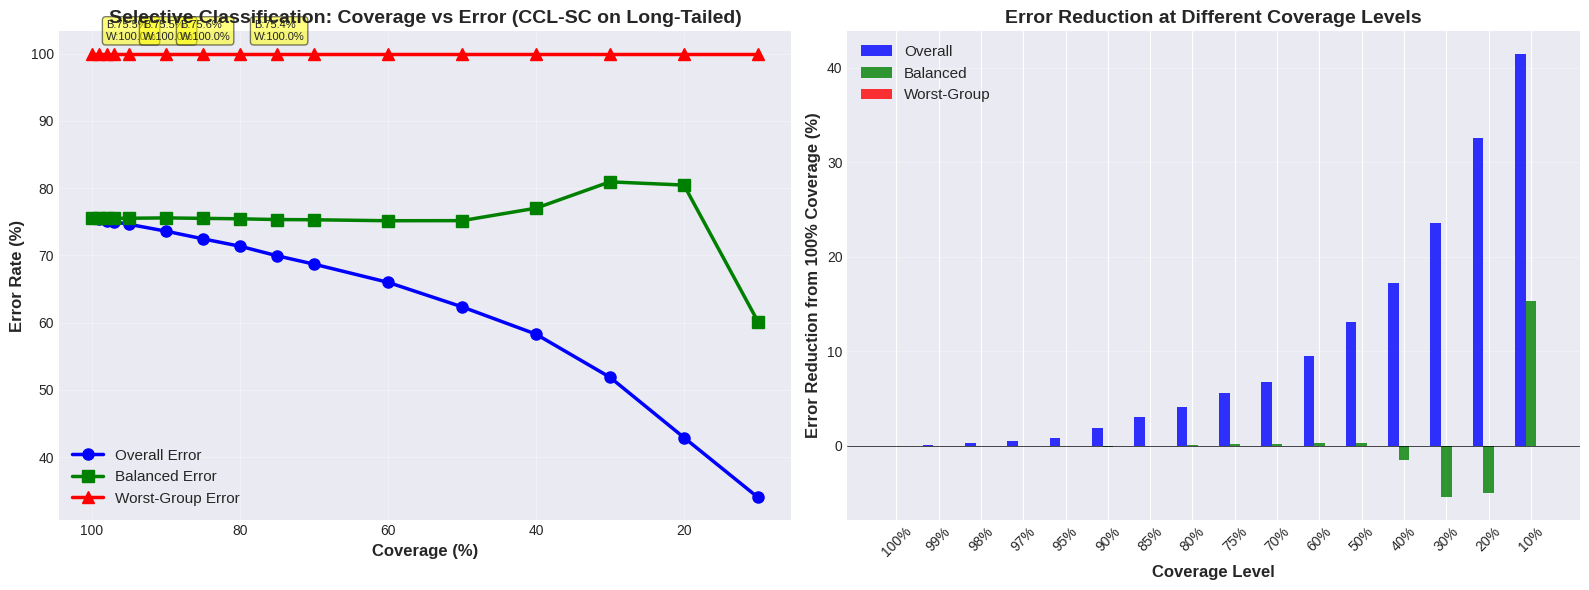


Coverage analysis saved to ./checkpoints/cclsc_longtailed_ir100/coverage_analysis.png


In [24]:
# Extract final coverage results
final_coverage = history['coverage_results'][-1]

# Create DataFrame
df_coverage = pd.DataFrame(final_coverage)

print("\nCoverage-Based Error Analysis:")
print("="*80)
display(df_coverage[['coverage', 'overall_error', 'balanced_error', 'worst_group_error']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Coverage vs Error curves
ax = axes[0]
ax.plot(df_coverage['coverage'], df_coverage['overall_error'], 
        marker='o', markersize=8, linewidth=2.5, label='Overall Error', color='blue')
ax.plot(df_coverage['coverage'], df_coverage['balanced_error'], 
        marker='s', markersize=8, linewidth=2.5, label='Balanced Error', color='green')
ax.plot(df_coverage['coverage'], df_coverage['worst_group_error'], 
        marker='^', markersize=8, linewidth=2.5, label='Worst-Group Error', color='red')
ax.set_xlabel('Coverage (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax.set_title('Selective Classification: Coverage vs Error (CCL-SC on Long-Tailed)', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# Highlight key coverage points
for cov in [100, 95, 90, 80]:
    row = df_coverage[df_coverage['coverage'] == cov]
    if len(row) > 0:
        bal_err = row['balanced_error'].values[0]
        worst_err = row['worst_group_error'].values[0]
        ax.annotate(f'B:{bal_err:.1f}%\nW:{worst_err:.1f}%', 
                    xy=(cov, worst_err), xytext=(10, 10), 
                    textcoords='offset points', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

# 2. Error reduction comparison
ax = axes[1]
overall_reduction = df_coverage['overall_error'].iloc[0] - df_coverage['overall_error']
balanced_reduction = df_coverage['balanced_error'].iloc[0] - df_coverage['balanced_error']
worst_reduction = df_coverage['worst_group_error'].iloc[0] - df_coverage['worst_group_error']

x = np.arange(len(df_coverage))
width = 0.25

ax.bar(x - width, overall_reduction, width, label='Overall', alpha=0.8, color='blue')
ax.bar(x, balanced_reduction, width, label='Balanced', alpha=0.8, color='green')
ax.bar(x + width, worst_reduction, width, label='Worst-Group', alpha=0.8, color='red')

ax.set_xlabel('Coverage Level', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Reduction from 100% Coverage (%)', fontweight='bold', fontsize=12)
ax.set_title('Error Reduction at Different Coverage Levels', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f"{int(c)}%" for c in df_coverage['coverage']], rotation=45)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'coverage_analysis.png'), dpi=150)
plt.show()

print(f"\nCoverage analysis saved to {config.save_dir}/coverage_analysis.png")

## 11. AURC Calculation: Balanced and Worst-Group Risk


AURC (Area Under Risk-Coverage Curve) - Lower is Better
AURC (Overall):     -0.549722
AURC (Balanced):    -0.682698
AURC (Worst-Group): -0.900000


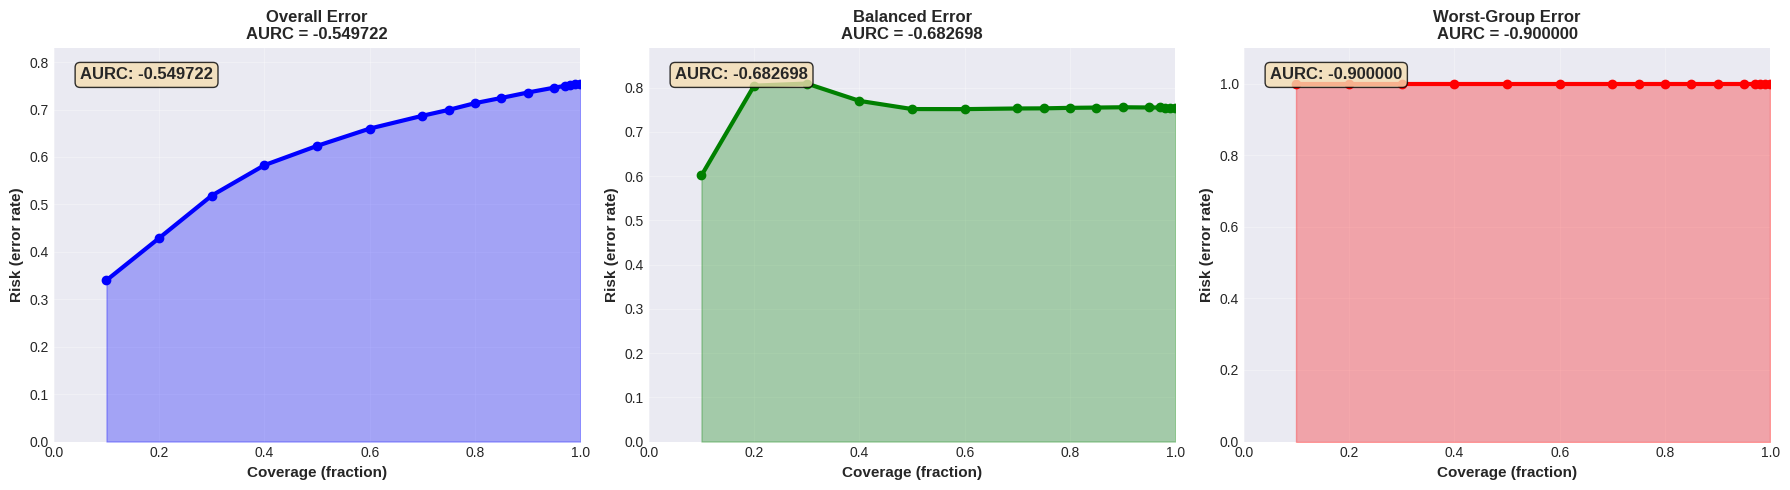


AURC analysis saved to ./checkpoints/cclsc_longtailed_ir100/aurc_analysis.png


In [25]:
def calculate_aurc(coverages, errors):
    """
    Calculate Area Under the Risk-Coverage curve
    AURC = integral of error rate over coverage
    Lower is better
    """
    # Sort by coverage (descending)
    sorted_indices = np.argsort(coverages)[::-1]
    sorted_cov = np.array(coverages)[sorted_indices]
    sorted_err = np.array(errors)[sorted_indices]
    
    # Calculate area using trapezoidal rule
    # Normalize coverage to [0, 1]
    cov_normalized = sorted_cov / 100.0
    err_normalized = sorted_err / 100.0
    
    aurc = np.trapezoid(err_normalized, cov_normalized)
    return aurc

# Calculate AURC for different metrics
coverages = df_coverage['coverage'].values
overall_errors = df_coverage['overall_error'].values
balanced_errors = df_coverage['balanced_error'].values
worst_errors = df_coverage['worst_group_error'].values

aurc_overall = calculate_aurc(coverages, overall_errors)
aurc_balanced = calculate_aurc(coverages, balanced_errors)
aurc_worst = calculate_aurc(coverages, worst_errors)

print("\n" + "="*80)
print("AURC (Area Under Risk-Coverage Curve) - Lower is Better")
print("="*80)
print(f"AURC (Overall):     {aurc_overall:.6f}")
print(f"AURC (Balanced):    {aurc_balanced:.6f}")
print(f"AURC (Worst-Group): {aurc_worst:.6f}")
print("="*80)

# Visualize AURC
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (ax, errors, title, color, aurc) in enumerate([
    (axes[0], overall_errors, 'Overall Error', 'blue', aurc_overall),
    (axes[1], balanced_errors, 'Balanced Error', 'green', aurc_balanced),
    (axes[2], worst_errors, 'Worst-Group Error', 'red', aurc_worst)
]):
    # Normalize for visualization
    cov_norm = coverages / 100.0
    err_norm = errors / 100.0
    
    # Plot curve
    ax.plot(cov_norm, err_norm, linewidth=3, color=color, marker='o', markersize=6)
    
    # Fill area under curve
    ax.fill_between(cov_norm, 0, err_norm, alpha=0.3, color=color)
    
    ax.set_xlabel('Coverage (fraction)', fontweight='bold', fontsize=11)
    ax.set_ylabel('Risk (error rate)', fontweight='bold', fontsize=11)
    ax.set_title(f'{title}\nAURC = {aurc:.6f}', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, max(err_norm) * 1.1])
    
    # Add text box with AURC value
    ax.text(0.05, 0.95, f'AURC: {aurc:.6f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=12, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(config.save_dir, 'aurc_analysis.png'), dpi=150)
plt.show()

print(f"\nAURC analysis saved to {config.save_dir}/aurc_analysis.png")

## 12. Summary Report

In [26]:
# Generate comprehensive summary
print("\n" + "="*100)
print(f"CCL-SC ON LONG-TAILED CIFAR-10 - FINAL REPORT (IR={config.imbalance_ratio})")
print("="*100)

print("\n1. OVERALL PERFORMANCE:")
print("-" * 100)
print(f"Final Test Accuracy (Overall):     {history['test_acc'][-1]:.2f}%")
print(f"Final Test Accuracy (Balanced):    {history['test_balanced_acc'][-1]:.2f}%")
print(f"Final Test Accuracy (Worst-Group): {history['test_worst_acc'][-1]:.2f}%")
print(f"\nBest Balanced Accuracy:             {best_balanced_acc:.2f}%")
print(f"Best Worst-Group Accuracy:          {best_worst_acc:.2f}%")

print("\n2. PER-CLASS ACCURACY:")
print("-" * 100)
for i, (name, acc, samples) in enumerate(zip(class_names, final_class_acc, [train_dist[i] for i in range(num_classes)])):
    print(f"Class {i} ({name:12s}): {acc:6.2f}%  (train samples: {samples:5d})")

print("\n3. COVERAGE-BASED ANALYSIS (Key Coverage Levels):")
print("-" * 100)
print(f"{'Coverage':<10} | {'Overall Err':<12} | {'Balanced Err':<13} | {'Worst Err':<10} | {'Bal Reduction':<14} | {'Worst Reduction'}")
print("-" * 100)

for cov in [100, 99, 95, 90, 85, 80, 75, 70]:
    row = df_coverage[df_coverage['coverage'] == cov]
    if len(row) > 0:
        overall_err = row['overall_error'].values[0]
        bal_err = row['balanced_error'].values[0]
        worst_err = row['worst_group_error'].values[0]
        
        bal_reduction = df_coverage['balanced_error'].iloc[0] - bal_err
        worst_reduction = df_coverage['worst_group_error'].iloc[0] - worst_err
        
        print(f"{cov:<10.0f} | {overall_err:<12.2f} | {bal_err:<13.2f} | {worst_err:<10.2f} | "
              f"{bal_reduction:<14.2f} | {worst_reduction:.2f}")

print("\n4. AURC (Area Under Risk-Coverage Curve):")
print("-" * 100)
print(f"AURC (Overall):     {aurc_overall:.6f}")
print(f"AURC (Balanced):    {aurc_balanced:.6f}  [Balanced risk metric]")
print(f"AURC (Worst-Group): {aurc_worst:.6f}  [Worst-case risk metric]")

print("\n5. KEY INSIGHTS:")
print("-" * 100)

# Calculate insights
bal_gap = history['test_acc'][-1] - history['test_balanced_acc'][-1]
worst_gap = history['test_acc'][-1] - history['test_worst_acc'][-1]
class_variance = np.var(final_class_acc)

# Error reduction at 80% coverage
row_100 = df_coverage[df_coverage['coverage'] == 100].iloc[0]
row_80 = df_coverage[df_coverage['coverage'] == 80].iloc[0]
bal_reduction_80 = row_100['balanced_error'] - row_80['balanced_error']
worst_reduction_80 = row_100['worst_group_error'] - row_80['worst_group_error']

print(f"• Performance Gap (Overall vs Balanced):   {bal_gap:.2f}%")
print(f"• Performance Gap (Overall vs Worst):     {worst_gap:.2f}%")
print(f"• Class Accuracy Variance:                {class_variance:.2f}")
print(f"• Balanced Error Reduction (100% → 80%):  {bal_reduction_80:.2f}%")
print(f"• Worst Error Reduction (100% → 80%):     {worst_reduction_80:.2f}%")

if bal_gap > 5:
    print(f"\n⚠️  Large gap between overall and balanced accuracy suggests class imbalance impact")
if worst_gap > 10:
    print(f"⚠️  Very large gap to worst-group indicates severe performance disparity")
if worst_reduction_80 < bal_reduction_80:
    print(f"⚠️  Selective classification less effective for worst-performing groups")

print("\n💡 CCL-SC METHODOLOGY:")
print("-" * 100)
print("• Combines Self-Adaptive Training (SAT) with Class-wise Contrastive Learning")
print("• Uses MoCo (Momentum Contrast) with dual queues for correct/error samples")
print("• Contrastive learning helps learn better feature representations")
print("• Should improve performance on minority classes compared to vanilla SAT")

print("\n" + "="*100)

# Save report to file
report_path = os.path.join(config.save_dir, 'summary_report.txt')
with open(report_path, 'w') as f:
    f.write(f"CCL-SC ON LONG-TAILED CIFAR-10 - SUMMARY REPORT (IR={config.imbalance_ratio})\n")
    f.write("="*100 + "\n\n")
    f.write(f"Final Test Accuracy (Overall):     {history['test_acc'][-1]:.2f}%\n")
    f.write(f"Final Test Accuracy (Balanced):    {history['test_balanced_acc'][-1]:.2f}%\n")
    f.write(f"Final Test Accuracy (Worst-Group): {history['test_worst_acc'][-1]:.2f}%\n\n")
    f.write(f"AURC (Overall):     {aurc_overall:.6f}\n")
    f.write(f"AURC (Balanced):    {aurc_balanced:.6f}\n")
    f.write(f"AURC (Worst-Group): {aurc_worst:.6f}\n")

print(f"\nSummary report saved to: {report_path}")

# Save coverage results to CSV
csv_path = os.path.join(config.save_dir, 'coverage_results.csv')
df_coverage[['coverage', 'overall_error', 'balanced_error', 'worst_group_error']].to_csv(csv_path, index=False)
print(f"Coverage results saved to: {csv_path}")

print("\n✅ Analysis complete!")


CCL-SC ON LONG-TAILED CIFAR-10 - FINAL REPORT (IR=100)

1. OVERALL PERFORMANCE:
----------------------------------------------------------------------------------------------------
Final Test Accuracy (Overall):     24.52%
Final Test Accuracy (Balanced):    24.52%
Final Test Accuracy (Worst-Group): 0.00%

Best Balanced Accuracy:             24.82%
Best Worst-Group Accuracy:          0.00%

2. PER-CLASS ACCURACY:
----------------------------------------------------------------------------------------------------
Class 0 (airplane    ):  92.10%  (train samples:  1000)
Class 1 (automobile  ):  81.80%  (train samples:   599)
Class 2 (bird        ):  71.30%  (train samples:   359)
Class 3 (cat         ):   0.00%  (train samples:   215)
Class 4 (deer        ):   0.00%  (train samples:   129)
Class 5 (dog         ):   0.00%  (train samples:    77)
Class 6 (frog        ):   0.00%  (train samples:    46)
Class 7 (horse       ):   0.00%  (train samples:    27)
Class 8 (ship        ):   0.00%  (